In [5]:
import plotting_functions
import pandas as pd
import numpy as np

# Exploratory Analysis of Real Commodities Data

## Currency Basket

We choose the returns of three currencies which are heavily linked to the performance of commodities marketsin order to create a market benchmark against which to compare the performance of each commodity. To this end, we consider the average of the returns of the Canadian Dollar (CAD), Australian Dollar (AUD), and the Mexican Peso when paired with the US Dollar (USD). The resulting augmented "commodities currency basket" series is analysed in this section.

In [6]:
# Create list of currency names
currency_list = ['CME Australian Dollar AUD',
                 'CME Mexican Peso',
                 'CME Canadian Dollar CAD']

# Initialise empty dataframes with full indexing
currency_dict = {currency:  pd.DataFrame([], index = pd.bdate_range(start = '1/1/1980', end = '7/31/2020')) for currency in currency_list}

# Loop through each currency and load the data into the waiting dataframne
for currency in currency_list:
    
    current_df = pd.read_csv('Data/Continuous Futures Series/{}.csv'.format(currency), index_col = 0, skiprows = 0, skipfooter = 1, header = 1, engine = 'python')
    current_df.index = pd.to_datetime(current_df.index)
    
    currency_dict[currency] = currency_dict[currency].join(current_df)

In [7]:
from plotting_functions import series_plot

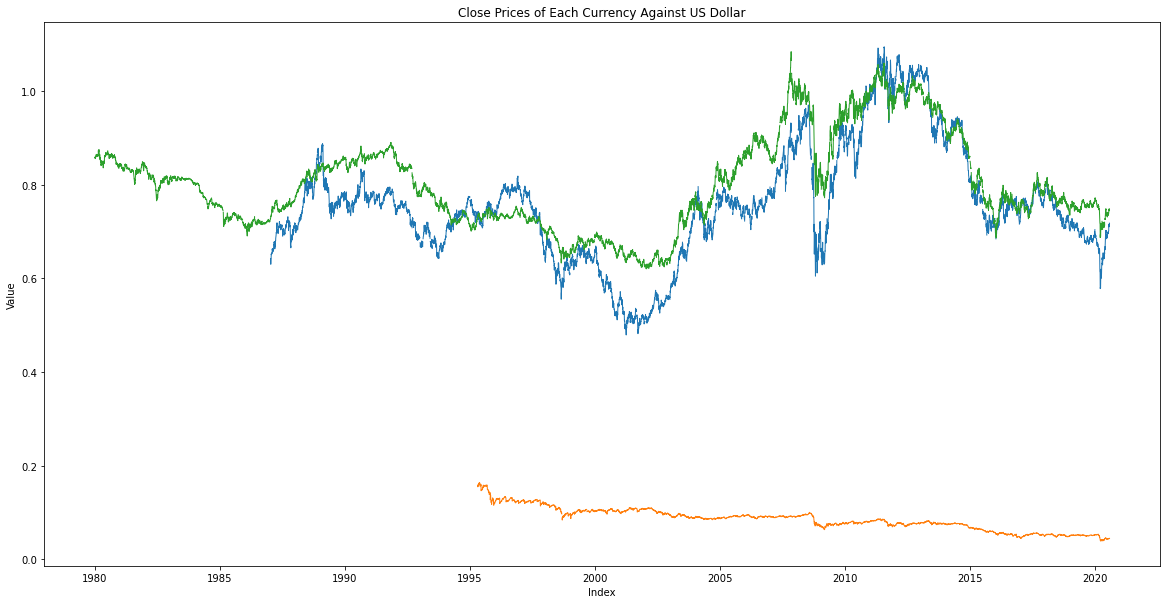

In [8]:
# Create empty dataframe of currency close prices to be filled in
currency_close_df = pd.DataFrame([], index = currency_dict['CME Canadian Dollar CAD'].index)

# Loop through each currency dataframe and pull its close price data
for currency in currency_list:
    
    currency_close_df[currency] = currency_dict[currency]['Close']
    
series_plot(currency_close_df,'Close Prices of Each Currency Against US Dollar')

While the CAD and AUD have data available back to 1980, the Peso as it is currently traded ws introduced in January 1996. As such, its series only has data available beginning near to this date. This will not be an issue, as 24 years of available daily data will be more than suitable for our purposes and we will see that our useable data range will be limited further still by similar constraints on the commodities returns data.

### Simple Average of Currencies

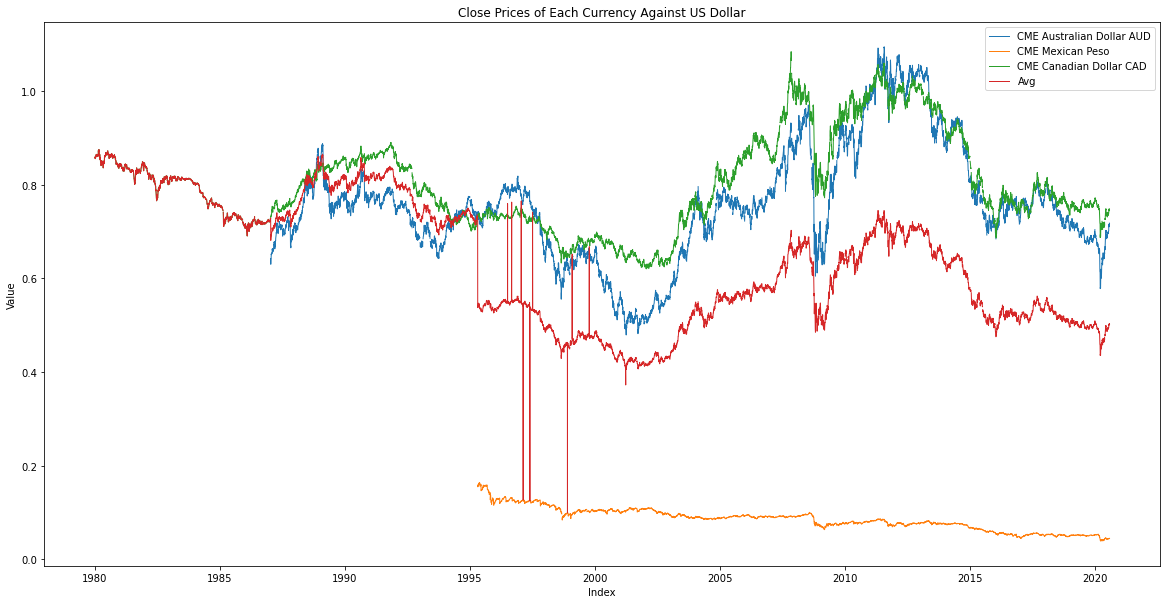

In [9]:
currency_close_df_copy = currency_close_df.copy()
currency_close_df_copy['Avg'] = currency_close_df.copy().mean(axis=1)

series_plot(currency_close_df_copy,'Close Prices of Each Currency Against US Dollar',legend=True)

The sharp spikes in the plotted data are a result of gaps in either the North American or Australian currencies. A sharp spike up is a result of missing data in the AUD, while a sharp spike down is caused by missing data in CAD and the Peso series. This is confirmed by the following plot, which is the same as the plot above but with missing data filled forwards.

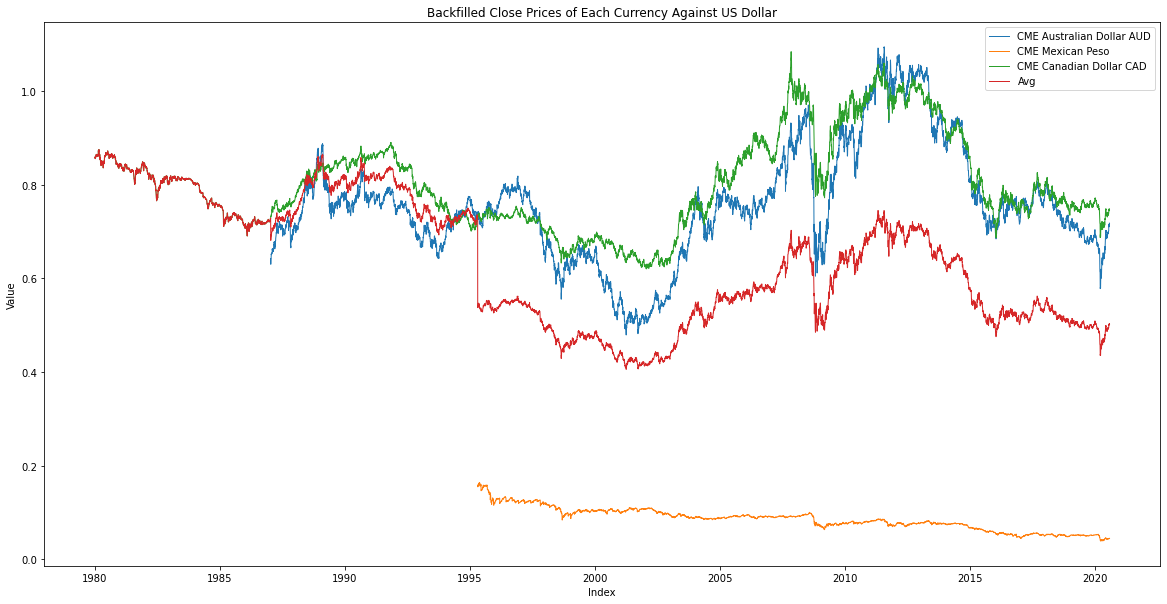

In [10]:
currency_close_df = currency_close_df.fillna(method='ffill')
currency_close_df['Avg'] = currency_close_df.mean(axis=1)

series_plot(currency_close_df,'Backfilled Close Prices of Each Currency Against US Dollar', legend=True)

We will choose not to backfill any missing dates, as this will be equivalent to having information about price data ahead of time. Instead we will fill empty data with the last known price point. As this is not possible for series that haven't yet registered any data, we truncate all currency data to the beginning date of the AUD.

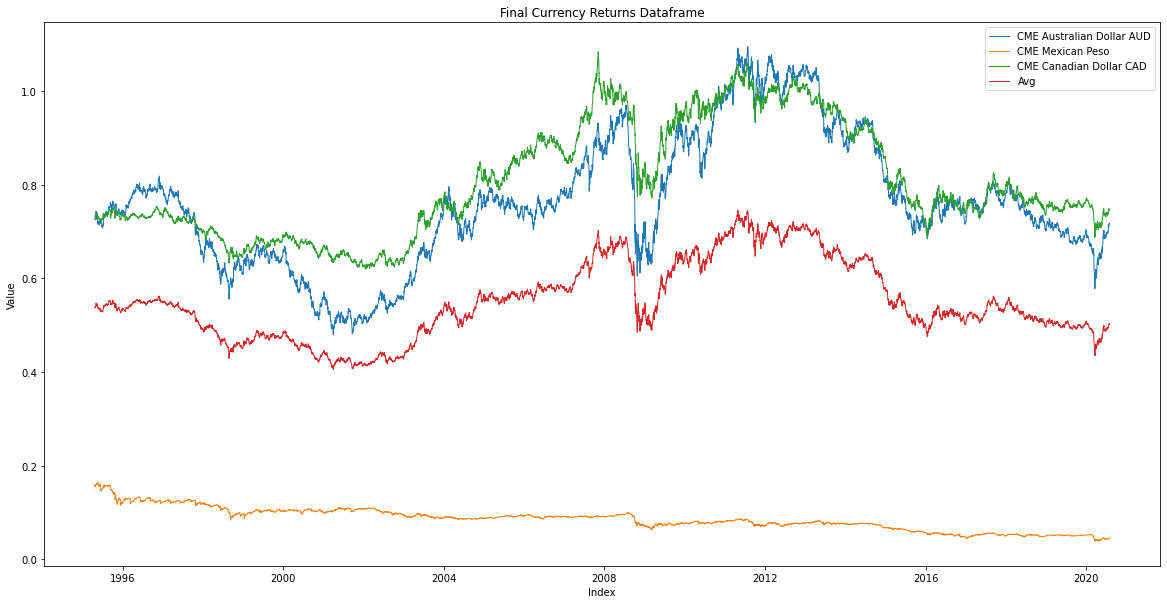

In [38]:
# Truncating currency data frame to first AUD date
mask = currency_close_df['CME Mexican Peso'].isnull()

currency_close_df = currency_close_df.loc[np.logical_not(mask)]
series_plot(currency_close_df, 'Final Currency Returns Dataframe', legend=True)

This leaves us with a final dataframe filled with returns data for each of our three currencies and their simple average. Next, we check that these returns are distributed appropriately.

### Distribution of Currencies Returns

Many desirable results necessitate the assumption that returns data is approximately normally distributed. Here we aim to validate that claim for our data. First, we constuct a series for each of our currencies which is mean-zero (by taking two day returns) and standardised by a rolling estimate of its standard deviation. Empircally we can show that a longer rolling period overestimates the variance of the returns and a shorter window underestimates it. This may be because the window size begins to take into account data from a distribution too different from the observation on the current day, a theme we will revisit often during this project. This also suggests that the data is not strictly stationary, as the observations do not have constant variance.

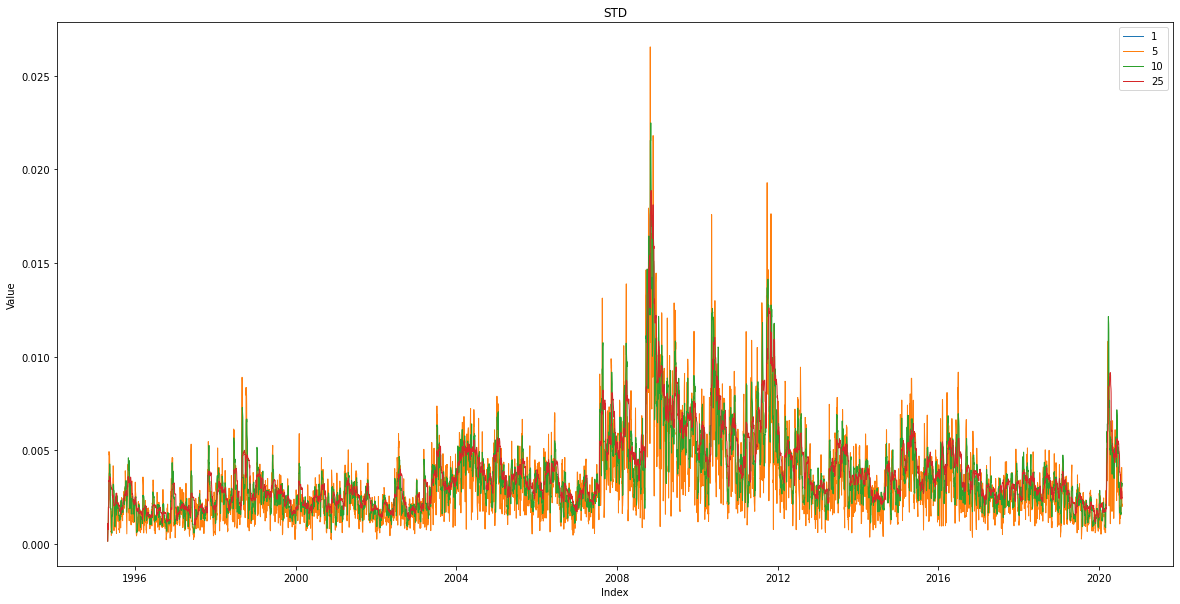

In [12]:
# Check series of standard deviation estimates for different rolling windows
std_plot = pd.DataFrame([], index=currency_close_df.index)
for window_size in [1,5,10,25]:
    std_plot[window_size] = currency_close_df['Avg'].diff(periods=2).rolling(window_size,min_periods=1).std()
series_plot(std_plot,'STD',legend=True)

We choose a rolling window of 12 days as this yields a distribution closest to a standard normal. This corresponds to around 2 business weeks.

In [13]:
# Normalised return dataframe
norm_currency_returns = pd.DataFrame([]).reindex_like(currency_close_df)

# Fill datafrane
for currency in currency_close_df:
    
    currency_std_series = currency_close_df[currency].rolling(12, min_periods = 1).std()
    
    norm_currency_returns[currency] = currency_close_df[currency].diff(periods=2) / currency_std_series

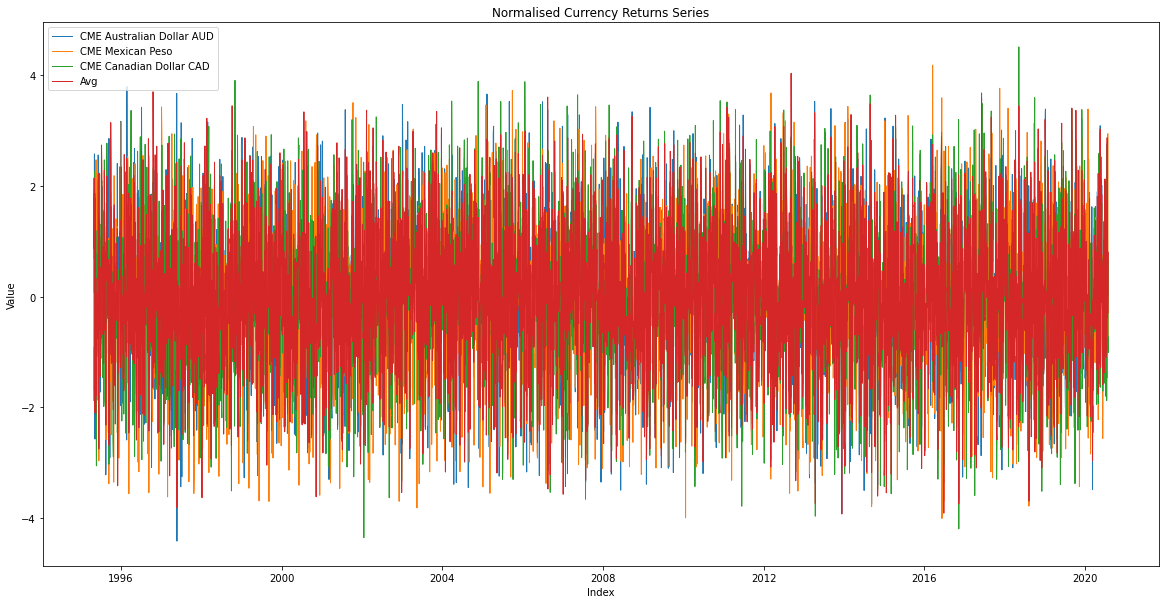

In [14]:
series_plot(norm_currency_returns,'Normalised Currency Returns Series', legend=True)

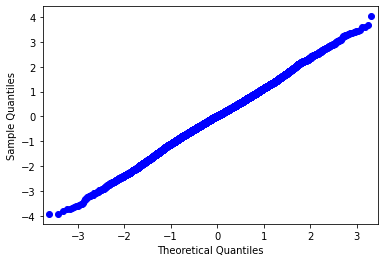

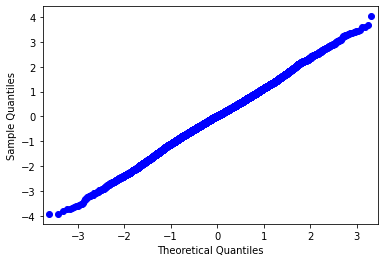

In [15]:
from statsmodels.graphics.gofplots import qqplot
qqplot(norm_currency_returns['Avg'])

With the choice of rolling estimate window size as outlined above, the QQ plots of the sample distribution indicate that the returns are approximately standard normally distributed. This is supported by the below Kernal Density Estimation of the currencies' average sample distribution.

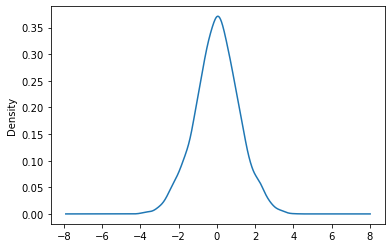

In [16]:
norm_currency_returns['Avg'].plot.kde()

### AutoCorrelation Plots


Now we check the autocorrelation function of the currencies' simple average. As it is the mean of three series with zero ACF, we expect this too to be zero.

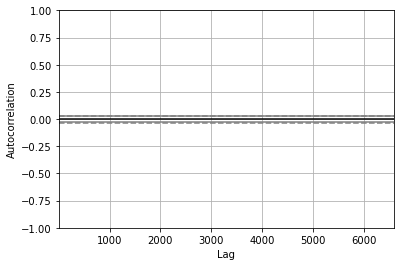

In [17]:
pd.plotting.autocorrelation_plot(norm_currency_returns['Avg'])

The simple average of the currencies has near zero autocorrelation at all lags. This validates our choice to not include auto-correlation structure to the currency composite.

## Commodities

We have access to the historical price data of the futures contracts of around 70 globally traded commodities. Whilst each series ends in July 2020, not all commodities have complete series, and not all commodities' series begin at the same date. Here we plot each series to gain a better understanding on the shape of our data.

In [18]:
# Create list of currency names
commodity_list = pd.read_csv('Data/Commodities_List.csv')['NAME']

# Initialise empty dataframes with full indexing
commodity_dict = {commodity:  pd.DataFrame([], index = pd.bdate_range(start = '1/1/1980', end = '7/31/2020')) for commodity in commodity_list}

# Loop through each currency and load the data into the waiting dataframne
for commodity in commodity_list:
    
    current_df = pd.read_csv('Data/Continuous Futures Series/{}.csv'.format(commodity), index_col = 0, skiprows = 0, skipfooter = 1, header = 1, engine = 'python')
    current_df.index = pd.to_datetime(current_df.index)
    
    commodity_dict[commodity] = commodity_dict[commodity].join(current_df)
commodity_dict

{'CBOE VIX Futures':            Symbol  Open   High    Low   Close  Change    Volume  Open Interest
 1980-01-01    NaN   NaN    NaN    NaN     NaN     NaN       NaN            NaN
 1980-01-02    NaN   NaN    NaN    NaN     NaN     NaN       NaN            NaN
 1980-01-03    NaN   NaN    NaN    NaN     NaN     NaN       NaN            NaN
 1980-01-04    NaN   NaN    NaN    NaN     NaN     NaN       NaN            NaN
 1980-01-07    NaN   NaN    NaN    NaN     NaN     NaN       NaN            NaN
 ...           ...   ...    ...    ...     ...     ...       ...            ...
 2020-07-27  VIQ20  28.8  29.00  27.50  27.525  -1.200   72752.0       268647.0
 2020-07-28  VIQ20  27.5  28.06  26.57  27.525   0.000  100722.0       268700.0
 2020-07-29  VIQ20  27.5  27.90  26.75  26.775  -0.750   71170.0       270530.0
 2020-07-30  VIQ20  26.9  29.71  26.66  27.175   0.400  139626.0            NaN
 2020-07-31  VIQ20  26.7  28.05  26.55  27.750   0.575       NaN            NaN
 
 [10589 rows x 8 c

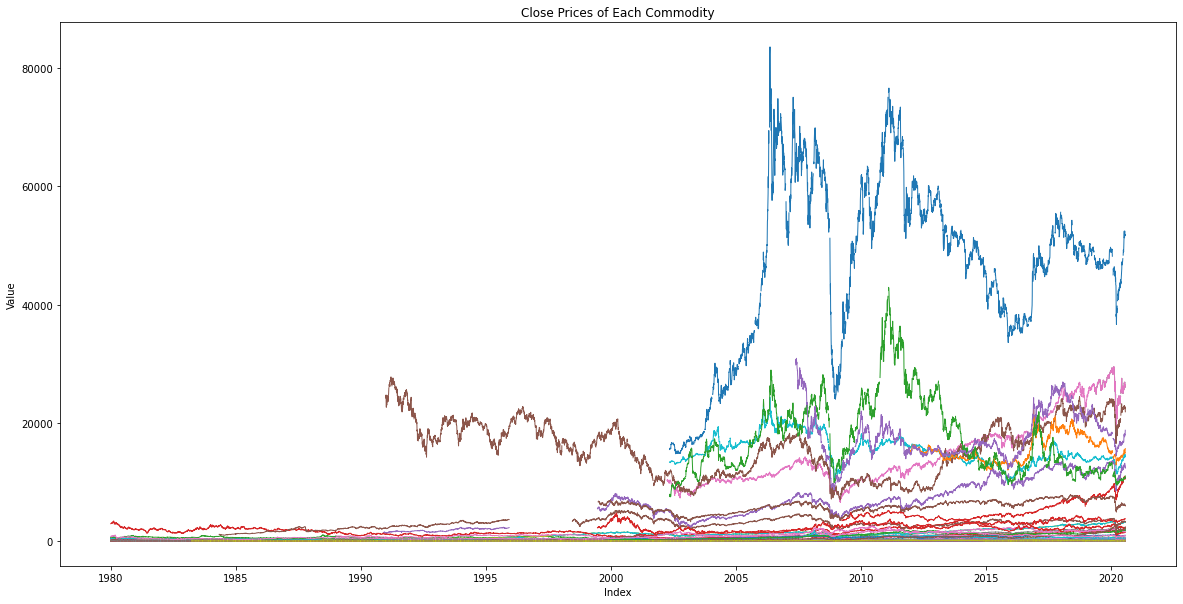

In [43]:
# Create empty dataframe of currency close prices to be filled in
commodity_close_df = pd.DataFrame([], index = commodity_dict['CBOE VIX Futures'].index)

# Loop through each currency dataframe and pull its close price data
for commodity in commodity_list:
    
    commodity_close_df[commodity] = commodity_dict[commodity]['Close']
    
series_plot(commodity_close_df,'Close Prices of Each Commodity')

To be consistent with our currencies data series, we trim these series to begin at the same date. As we will not use all of the commodities series in the same analyses, we do not trim them to their minimum index yet.

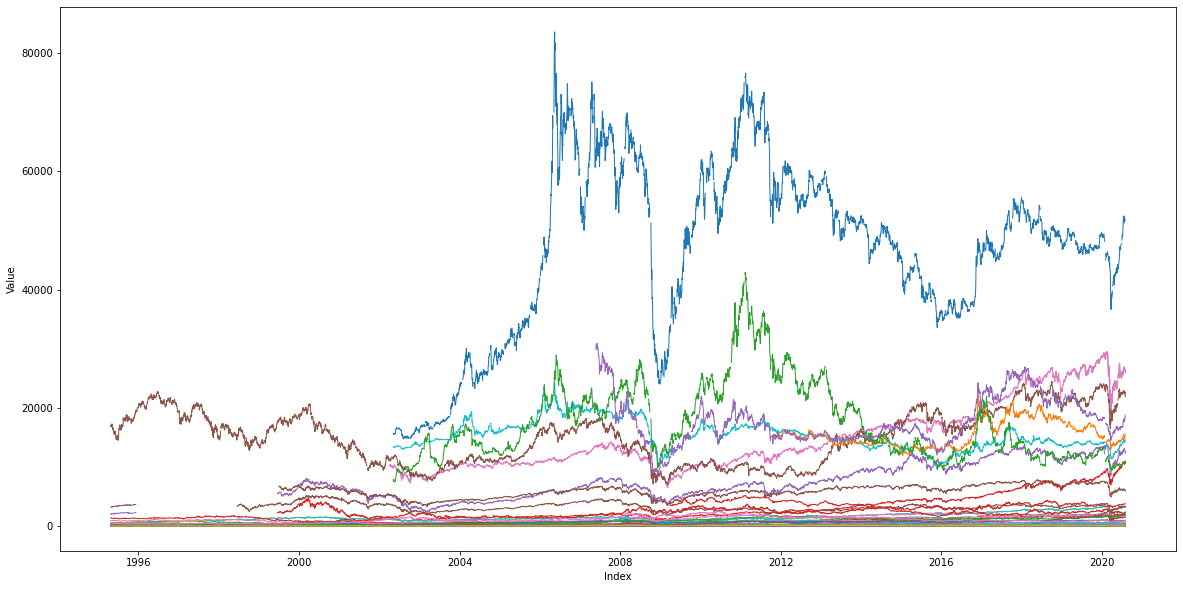

In [45]:
commodity_close_df = commodity_close_df.loc[currency_close_df['Avg'].index]
series_plot(commodity_close_df,'')

### Distribution of Commodity Returns

Here we evaluate the distribution of the returns data in the same way that we did for the currencies series. First, we constuct a series for each of our currencies which is mean-zero (by taking two day returns) and standardised by a rolling estimate of its standard deviation. For consistency we will use the same window size as we did for the currencies.

In [46]:
# Check series of standard deviation estimates for different rolling windows
std_plot = pd.DataFrame([], index=commodity_close_df.index)
for window_size in [1,5,10,25]:
    std_plot[window_size] = commodity_close_df['Avg'].diff(periods=2).rolling(window_size,min_periods=1).std()
series_plot(std_plot,'STD',legend=True)

KeyError: 'Avg'

We choose a rolling window of 12 days as this yields a distribution closest to a standard normal. This corresponds to around 2 business weeks.

In [13]:
# Normalised return dataframe
norm_currency_returns = pd.DataFrame([]).reindex_like(currency_close_df)

# Fill datafrane
for currency in currency_close_df:
    
    currency_std_series = currency_close_df[currency].rolling(12, min_periods = 1).std()
    
    norm_currency_returns[currency] = currency_close_df[currency].diff(periods=2) / currency_std_series

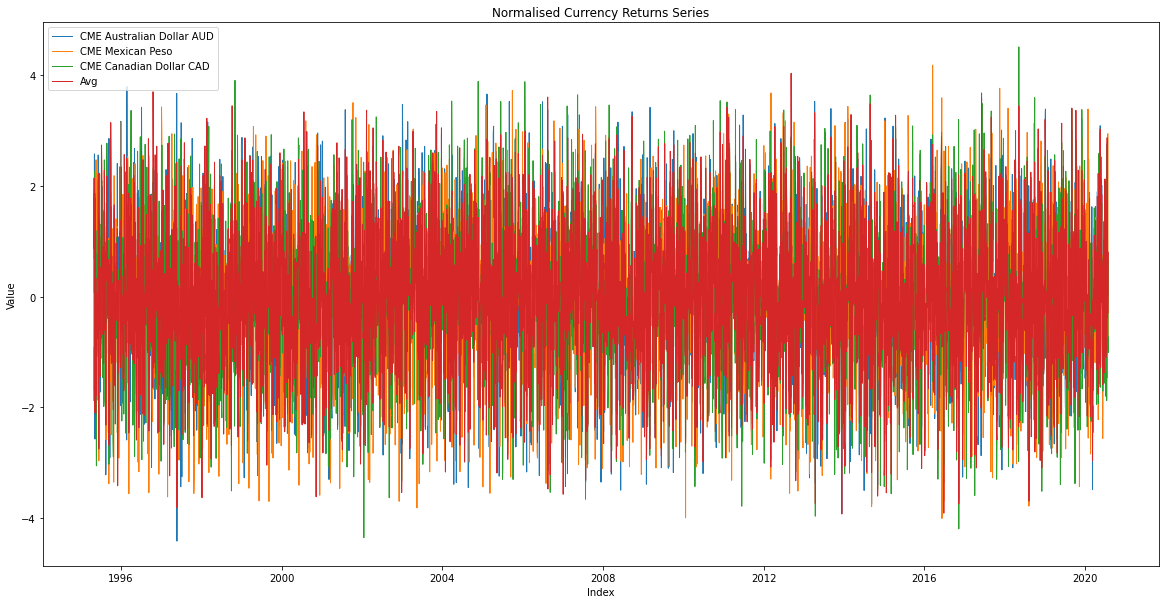

In [14]:
series_plot(norm_currency_returns,'Normalised Currency Returns Series', legend=True)

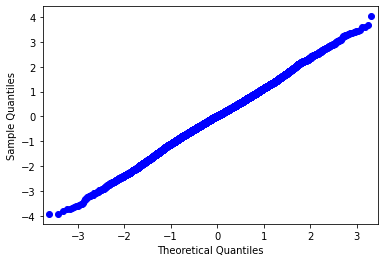

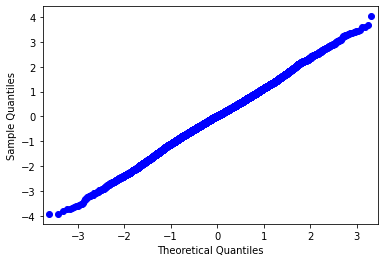

In [15]:
from statsmodels.graphics.gofplots import qqplot
qqplot(norm_currency_returns['Avg'])

With the choice of rolling estimate window size as outlined above, the QQ plots of the sample distribution indicate that the returns are approximately standard normally distributed. This is supported by the below Kernal Density Estimation of the currencies' average sample distribution.

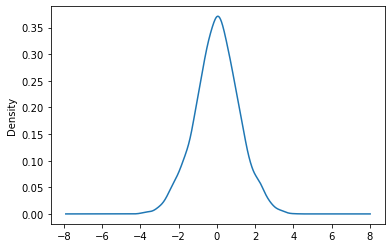

In [16]:
norm_currency_returns['Avg'].plot.kde()

### AutoCorrelation Plots


Now we check the autocorrelation function of the currencies' simple average. As it is the mean of three series with zero ACF, we expect this too to be zero.

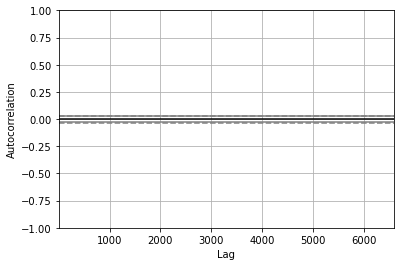

In [17]:
pd.plotting.autocorrelation_plot(norm_currency_returns['Avg'])

The simple average of the currencies has near zero autocorrelation at all lags. This validates our choice to not include auto-correlation structure to the currency composite.

### Data Validation

First we check that our assumption that these currencies work as a suitable benchmark for the commodities market as a whole. We do this by finding the correlation of this baskets returns with the returns of the rest of the market.